In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from pandas import datetime
import warnings
warnings.filterwarnings("ignore")
from statsmodels.distributions.empirical_distribution import ECDF
# time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# prophet by Facebook
#from fbprophet import Prophet

In [180]:
#Load the data into pandas dataframe
train_d = pd.read_csv('train.csv')
test_d = pd.read_csv('test.csv')
store_d = pd.read_csv('store.csv')

In [181]:
# Take a glimse of each data frame
train_d.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [182]:
test_d.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [183]:
store_d.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


#### Understanding the size of each data set, and counting missing values in each column

In [184]:
#Getting the size of each data set
print(train_d.shape)
print('-------------')
print(test_d.shape)
print('-------------')
print(store_d.shape)

(1017209, 9)
-------------
(41088, 8)
-------------
(1115, 10)


In [185]:
# Count missing values in each data set
print(train_d.isna().sum())
print('-------------------')
print(test_d.isna().sum())
print('-------------------')
print(store_d.isna().sum())

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64
-------------------
Id                0
Store             0
DayOfWeek         0
Date              0
Open             11
Promo             0
StateHoliday      0
SchoolHoliday     0
dtype: int64
-------------------
Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64


### Open stores which recorded no sales in a day

In [186]:
no_sales = train_d[(train_d.Open != 0) & (train_d.Sales == 0)]
print("In total, some open stores recorded 0 sales in", no_sales.shape[0],'days')


In total, some open stores recorded 0 sales in 54 days


### Are there closed stores in our data? Let's check!


In [187]:
train_d.shape

(1017209, 9)

In [188]:
# closed stores
train_d[(train_d.Open == 0) & (train_d.Sales == 0)].shape

(172817, 9)

There are 172817 closed stores in our training data. This is roughly 17% of the training data set. We can drop it to avoid biases in our training data 

In [189]:
# Drop enteries with no sales 
train_d = train_d[(train_d["Open"] != 0) & (train_d['Sales'] != 0)]

In [190]:
train_d.shape

(844338, 9)

### Discussion

The train data set has a total of 1017209 entries and 9 columns with no missing values. The test data set has 41088 entries and 8 columns. The 'open' column has 11 null entries. The store data set has 1115 entries and 8 columns. The 'CompetitionDistanc' column has 3 missing entries, 'CompetitionOpenSinceMonth' and 'CompetitionOpenSinceYear' both have 354 missing values. 'Promo2SinceWeek', 'Promo2SinceYear', and 'promoInterval' all have 544 missing values. We will handle these missing values in later steps

### Handling date columns - converting the 'Date' column into datetime and extracting day, month, year from it.

In [191]:
#Train_d
train_d['Date'] = pd.to_datetime(train_d['Date'])
train_d['Year'] = train_d['Date'].dt.year
train_d['Month'] = train_d['Date'].dt.month
train_d['Day'] = train_d['Date'].dt.day
train_d['WeekOfYear'] = train_d['Date'].dt.weekofyear

In [192]:
#Make the date column the index of the data frame
train_d.set_index('Date')

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear
Date,,,,,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1,2015,7,31,31
2015-07-31,2,5,6064,625,1,1,0,1,2015,7,31,31
2015-07-31,3,5,8314,821,1,1,0,1,2015,7,31,31
2015-07-31,4,5,13995,1498,1,1,0,1,2015,7,31,31
2015-07-31,5,5,4822,559,1,1,0,1,2015,7,31,31
2015-07-31,6,5,5651,589,1,1,0,1,2015,7,31,31
2015-07-31,7,5,15344,1414,1,1,0,1,2015,7,31,31
2015-07-31,8,5,8492,833,1,1,0,1,2015,7,31,31
2015-07-31,9,5,8565,687,1,1,0,1,2015,7,31,31


In [193]:
# Add a new column and calculate the average customer expenditure per day
train_d['SalePerCustomer'] = train_d['Sales']/train_d['Customers']
train_d['SalePerCustomer'].mean()

9.493641491077057

This means customers spend roughly $9.5/day

### Store data 

Now let's handle the missing values in the store data. We replace the missing values with the median of each column

In [194]:
# fill NaN with a median value (skewed distribuion)
store_d['CompetitionDistance'].fillna(store_d['CompetitionDistance'].median(), inplace = True)
store_d.fillna(0, inplace = True)
# Replace missing values in the 'PromoInterval' column with the previous dates
#store_d['PromoInterval'].fillna( method ='backfill', inplace = True)


In [195]:
store_d.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,0.0,0.0,0
4,5,a,a,29910.0,4.0,2015.0,0,0.0,0.0,0


In [196]:
store_d.isna().sum()

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

In [197]:
# by specifying inner join we make sure that only those observations 
# that are present in both train and store sets are merged together
train_store = pd.merge(train_d, store_d, how = 'inner', on = 'Store')
#train_store.set_index('Date', inplace = True)
print("In total: ", train_store.shape)

train_store.head()

In total:  (844338, 23)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,...,SalePerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,2015,...,9.482883,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,2015-07-30,5020,546,1,1,0,1,2015,...,9.194139,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,2015-07-29,4782,523,1,1,0,1,2015,...,9.143403,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,2015-07-28,5011,560,1,1,0,1,2015,...,8.948214,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,2015-07-27,6102,612,1,1,0,1,2015,...,9.970588,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


In [198]:
# Let's check the avergae sales per store type
train_store.groupby('StoreType')['Sales'].mean()

StoreType
a     6925.697986
b    10233.380141
c     6933.126425
d     6822.300064
Name: Sales, dtype: float64

We can see that store type b has the highest avarage sales - 10233 dollars while store type d has the lowest of 6822 dollars

In [199]:
train_store.groupby('StoreType')['Customers', 'Sales'].sum()

,Customers,Sales
StoreType,,
a,363541431,3165334859
b,31465616,159231395
c,92129705,783221426
d,156904995,1765392943


Store type a and d has the highest number of customers and sales among all the store types. Let's check the sales trends among stores!

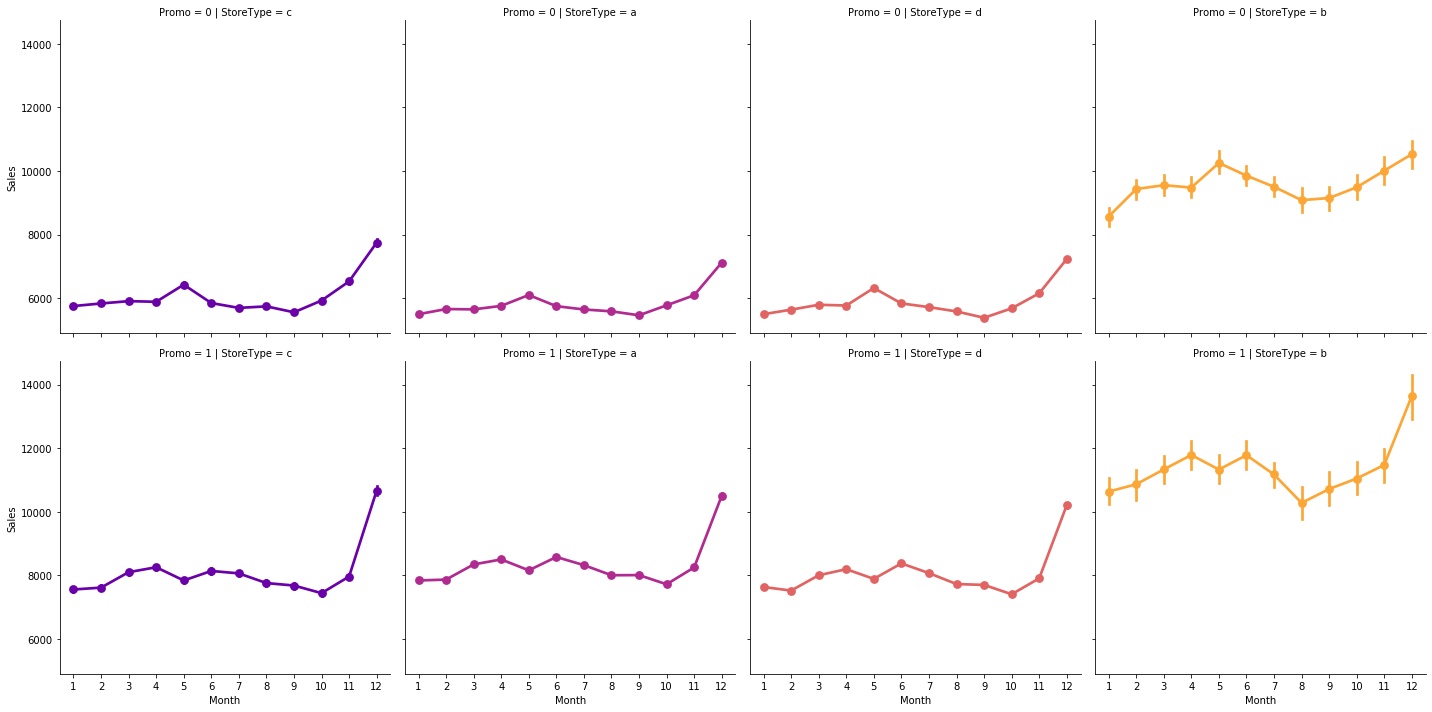

In [200]:
#Monthly sales trends per store type
sns.factorplot(data = train_store, x = 'Month', y = "Sales", 
               col = 'StoreType', # per store type in cols
               palette = 'plasma',
               hue = 'StoreType',
               row = 'Promo', # per promo in the store in rows
               ) 

There is a common trend across all store types in sales. Sales are almost flat or show litle growth from January to September across all store types and a sharp rise from November. We can notice that in all cases, the Promo has increased sales for atleast 20%. Store type b shows best performance in terms of sales as the graphs show. It starts from a higher value around 10000 dollars and never falls below that in sales. All other store types starts out at 8000 dollars or below and fall as low as the starting point as the months progress. Let's confirm this by ploting the sales per customer!

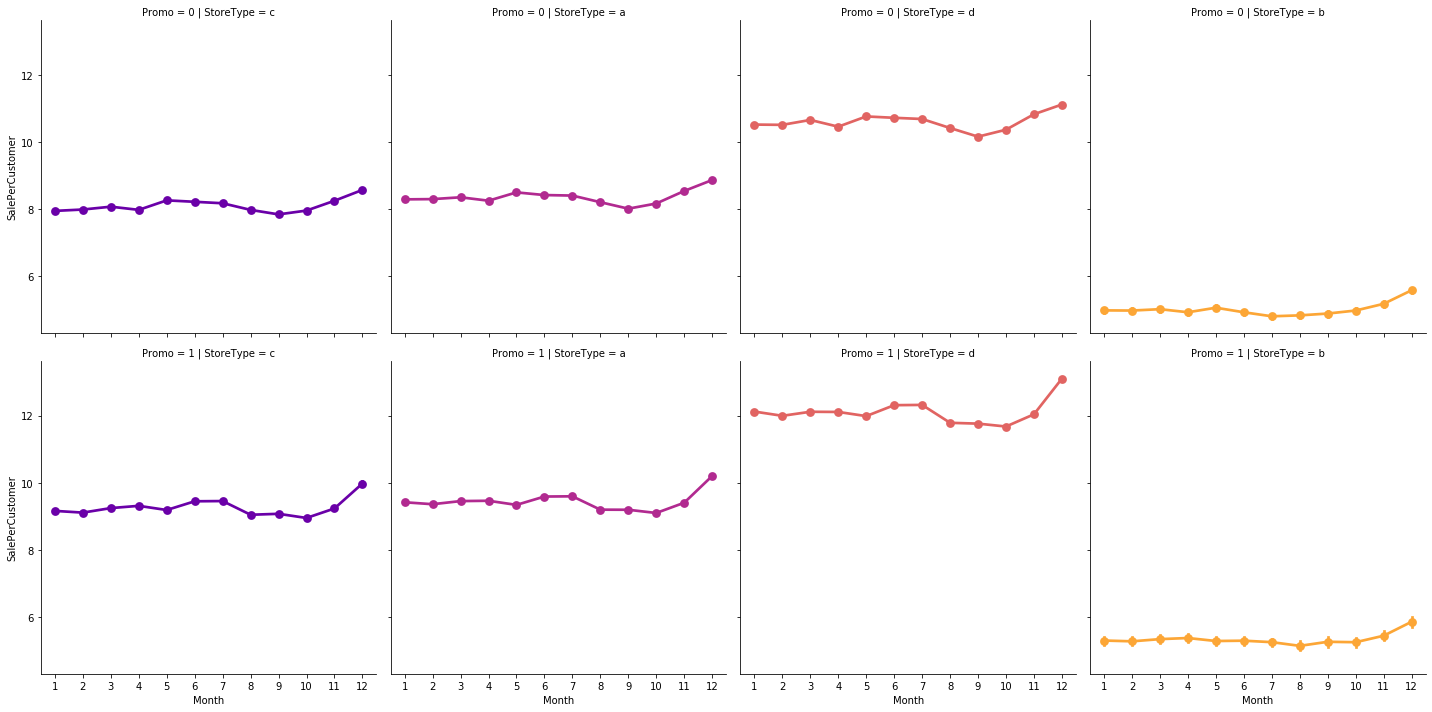

In [201]:
# sale per month per customer trends
sns.factorplot(data = train_store, x = 'Month', y = "SalePerCustomer", 
               col = 'StoreType', # per store type in cols
               palette = 'plasma',
               hue = 'StoreType',
               row = 'Promo', # per promo in the store in rows
               ) 

The sales per customer per month plot reveals that store type b is actually not the best performing store in terms of sales but store type d is! All the other store types seems to be performing better than b as well! This is something the aggregrated sales could not reveal. Let's investigate further!

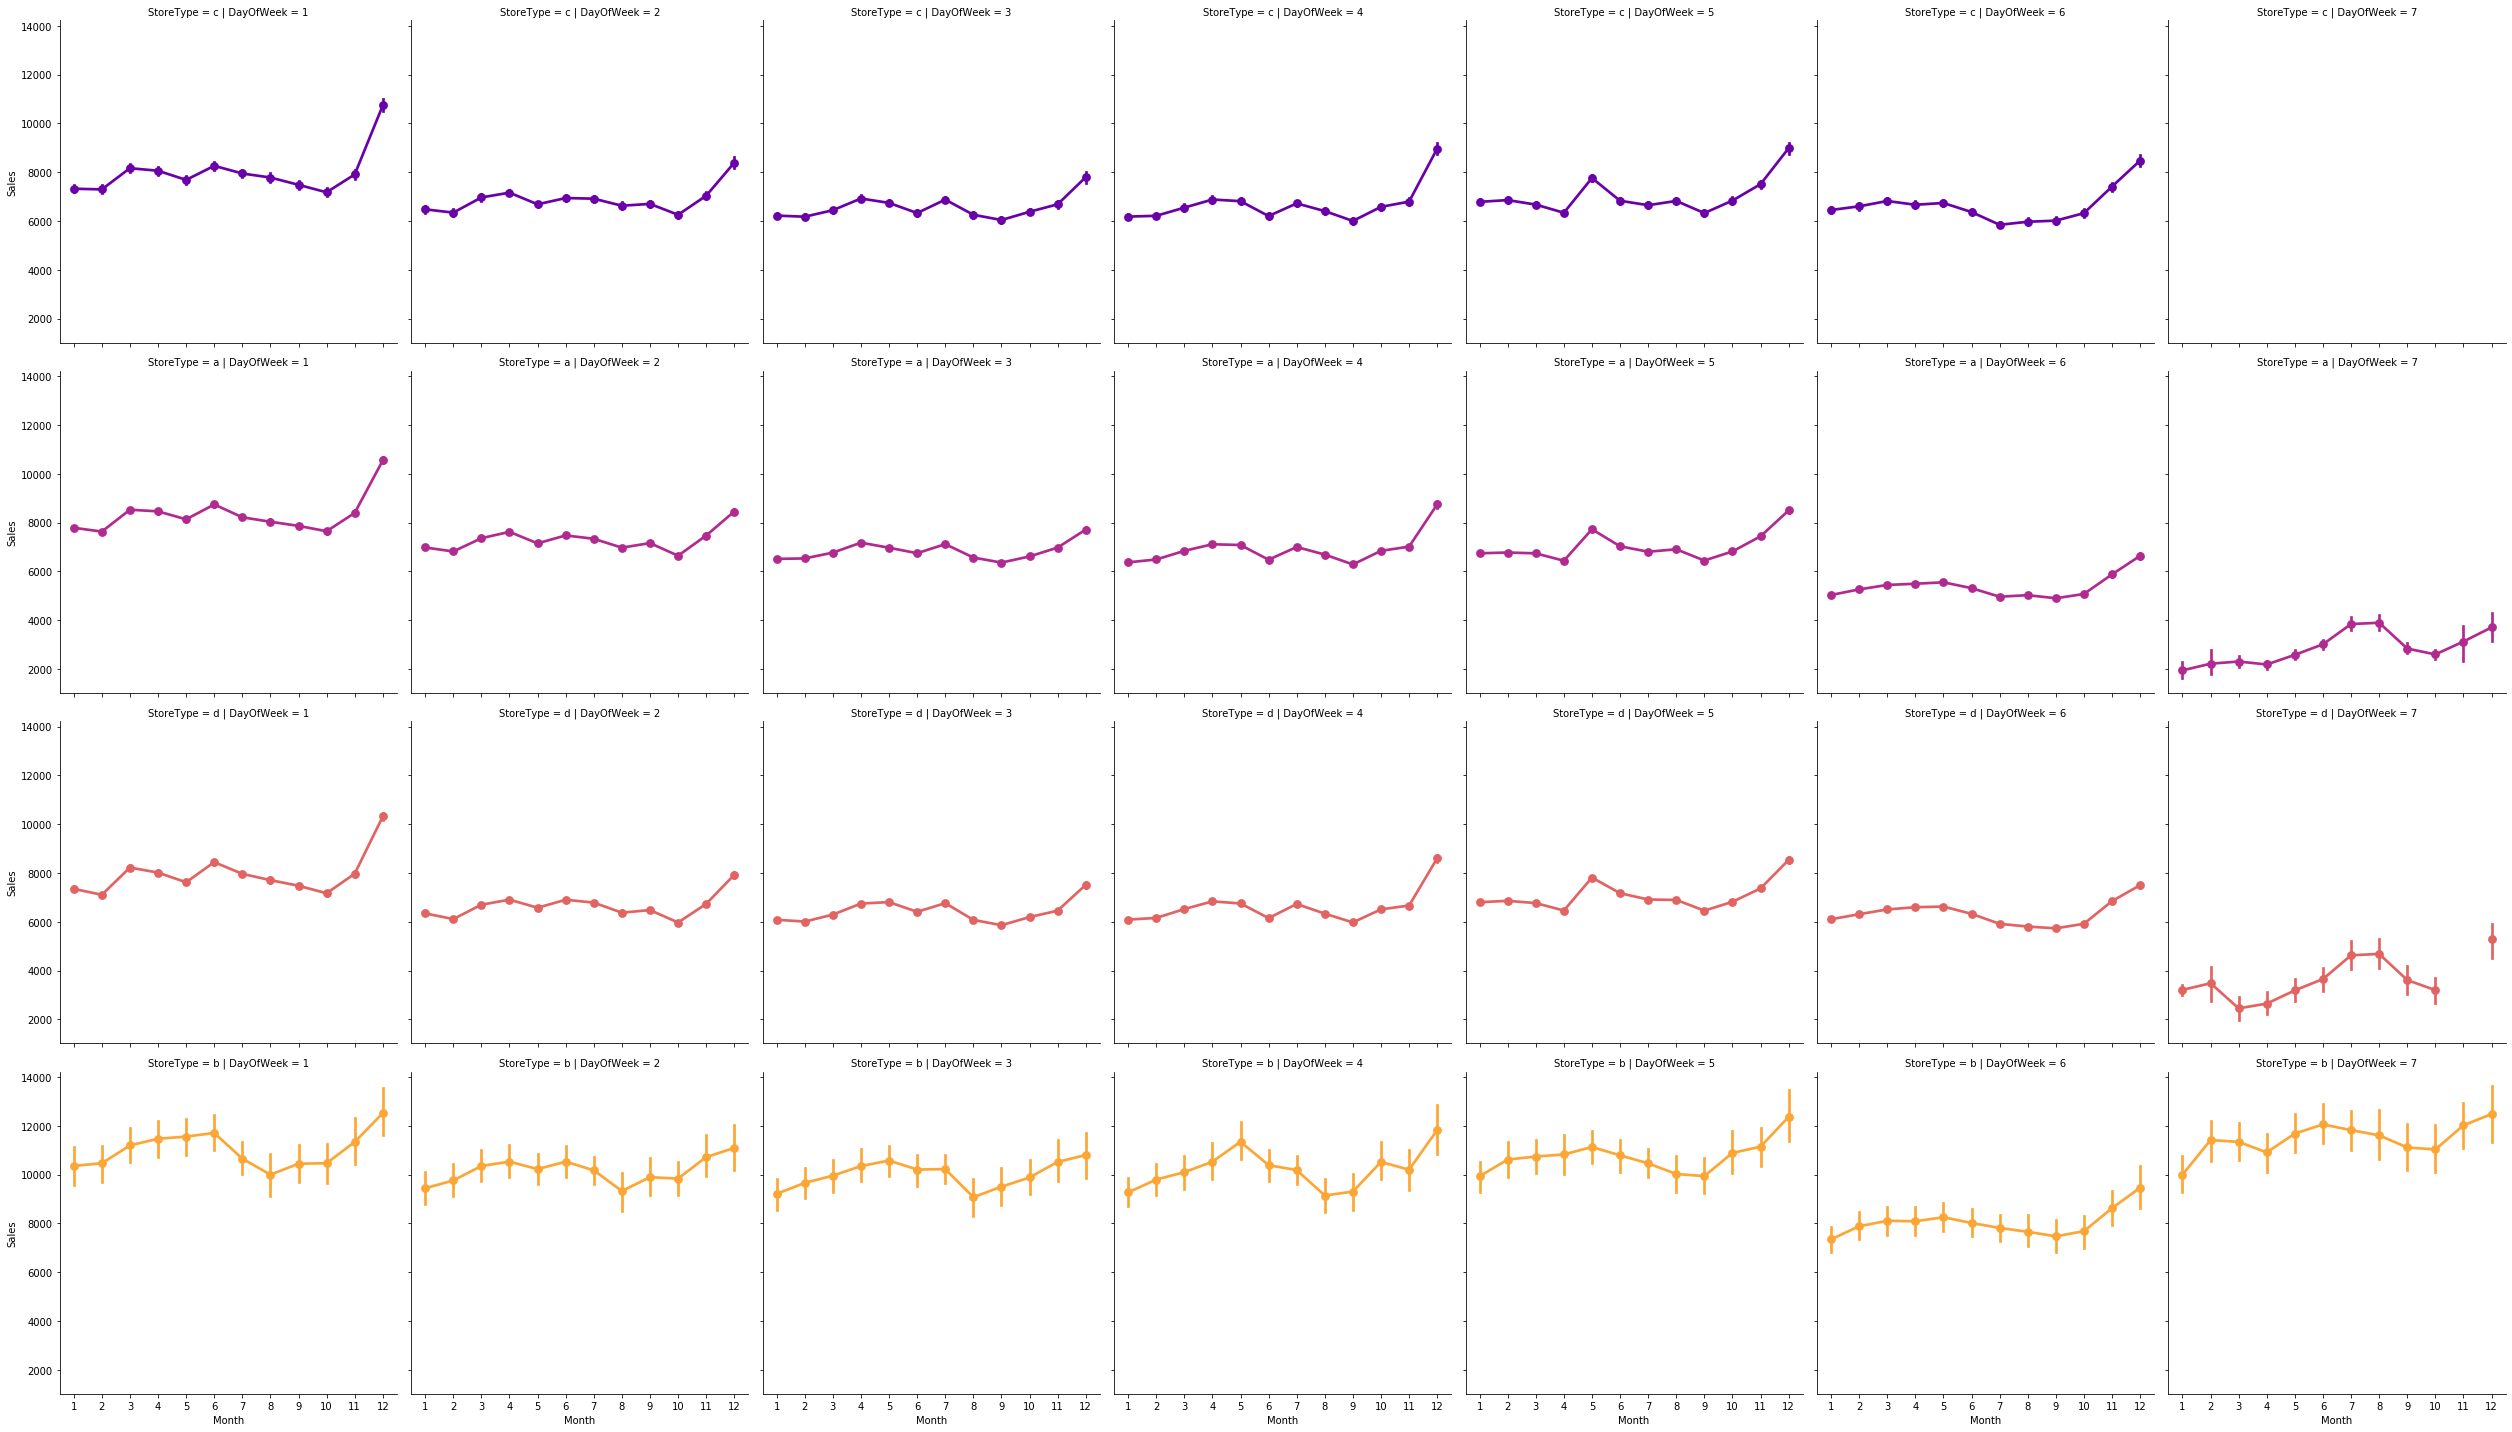

In [202]:
# customers
sns.factorplot(data = train_store, x = 'Month', y = "Sales", 
               col = 'DayOfWeek', # per store type in cols
               palette = 'plasma',
               hue = 'StoreType',
               row = 'StoreType', # per store type in rows
               ) 

We can see that store type c is always closed on Sunday throughout the year  and d closes on Sunday only from around october to December 

In [203]:
# competition open time (in months)
train_store['CompetitionOpen'] = 12 * (train_store.Year - train_store.CompetitionOpenSinceYear) + \
        (train_store.Month - train_store.CompetitionOpenSinceMonth)
    
# Promo open time
train_store['PromoOpen'] = 12 * (train_store.Year - train_store.Promo2SinceYear) + \
        (train_store.WeekOfYear - train_store.Promo2SinceWeek) / 4.0

# replace NA's by 0
train_store.fillna(0, inplace = True)

# average PromoOpen time and CompetitionOpen time per store type
train_store.loc[:, ['StoreType', 'Sales', 'Customers', 'PromoOpen', 'CompetitionOpen']].groupby('StoreType').mean()

,Sales,Customers,PromoOpen,CompetitionOpen
StoreType,,,,
a,6925.697986,795.422370,12918.492198,7115.514452
b,10233.380141,2022.211825,17199.328069,11364.495244
c,6933.126425,815.538073,12158.636107,6745.418694
d,6822.300064,606.353935,10421.916846,9028.526526


In our previous analysis showing the number of customers and sales per month per store type revealed that store type a and d are are have the highest numbers. Despite this, they are not the ones that face the most aggressive competition. It's rather store types b and c that face aggressive competition from other stores.

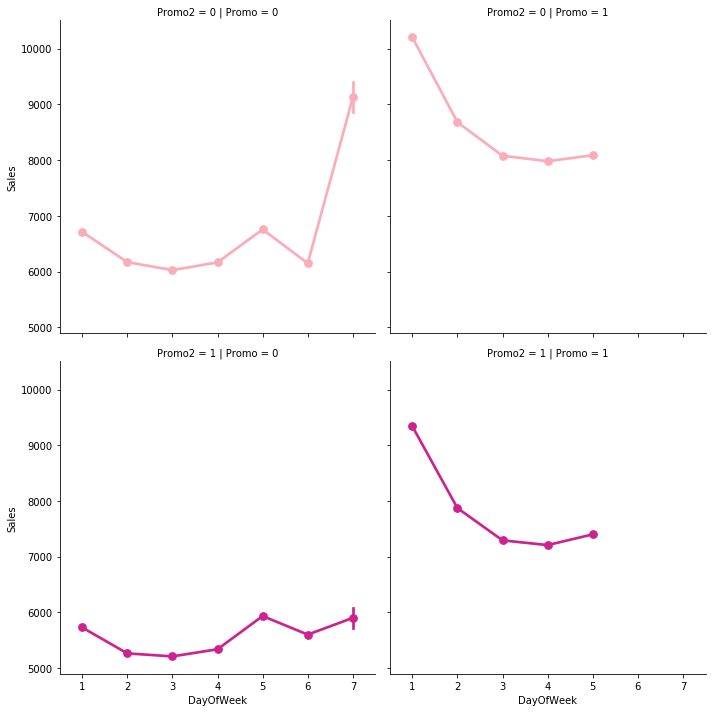

In [204]:
# sale per customer trends
sns.factorplot(data = train_store, x = 'DayOfWeek', y = "Sales", 
               col = 'Promo', 
               row = 'Promo2',
               hue = 'Promo2',
               palette = 'RdPu') 

When both promo1 and promo2 or promo1 only is running, sales tend to peek on Mondays. Sales peek on Sundays when both promos are not running. Running promo2 only doesn't seem to have a great impact on sales.

#### Seasonality analysis

In [177]:
# preparation: input should be float type
train['Sales'] = train['Sales'] * 1.0

# store types
sales_a = train[train.Store == 2]['Sales']
sales_b = train[train.Store == 85]['Sales'].sort_index(ascending = True) # solve the reverse order
sales_c = train[train.Store == 1]['Sales']
sales_d = train[train.Store == 13]['Sales']

f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (12, 13))

# store types
sales_a.resample('W').sum().plot(color = c, ax = ax1)
sales_b.resample('W').sum().plot(color = c, ax = ax2)
sales_c.resample('W').sum().plot(color = c, ax = ax3)
sales_d.resample('W').sum().plot(color = c, ax = ax4)

In [179]:
#train_store.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,...,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,CompetitionOpen,PromoOpen
Date,,,,,,,,,,,,,,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1,2015,7,...,a,1270.0,9.0,2008.0,0,0.0,0.0,0,82.0,24187.75
2015-07-30,1,4,5020,546,1,1,0,1,2015,7,...,a,1270.0,9.0,2008.0,0,0.0,0.0,0,82.0,24187.75
2015-07-29,1,3,4782,523,1,1,0,1,2015,7,...,a,1270.0,9.0,2008.0,0,0.0,0.0,0,82.0,24187.75
2015-07-28,1,2,5011,560,1,1,0,1,2015,7,...,a,1270.0,9.0,2008.0,0,0.0,0.0,0,82.0,24187.75
2015-07-27,1,1,6102,612,1,1,0,1,2015,7,...,a,1270.0,9.0,2008.0,0,0.0,0.0,0,82.0,24187.75
